### Main idea from Chih-Ling Hsu, https://chih-ling-hsu.github.io/2018/05/14/NYC

In [1]:
import pandas as pd
import numpy as np
import urllib.request
import zipfile
import random
import itertools
import math
import shapefile
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch
import matplotlib as plt
import matplotlib.mlab
import matplotlib.pyplot


plt.pyplot.style.use('ggplot')
%matplotlib inline

In [2]:
# There are 0s in trip_distance tab, which means trip_distance is smaller than 0.01 miles
# Such short distance trip may not reflect godness of service, hence we remove them 
# Besides, we add columns of pickup and dropoff time
def preprocess(file_list):
    df_list = []
    for file in file_list:
        df = pd.read_csv(file)
        df = df[df["trip_distance"] != 0]
        try:
            df['pickup_hour'] = [x[11:13] for x in df['lpep_pickup_datetime']]
            df['dropoff_hour'] = [x[11:13] for x in df['lpep_dropoff_datetime']]
        except KeyError:
            df['pickup_hour'] = [x[11:13] for x in df['tpep_pickup_datetime']]
            df['dropoff_hour'] = [x[11:13] for x in df['tpep_dropoff_datetime']]
        df_list.append(df)
    return df_list

In [3]:
# Convert location id to geo-coordinates
def compute_coordinate(zone):
    xy = []
    for sr in zone.shapeRecords():
        shape = sr.shape
        record = sr.record
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        xy.append([x, y])
    return pd.DataFrame(xy, columns=["longitude", "latitude"])

In [4]:
# From:
# http://dl.booktolearn.com/ebooks2/computer/python/9781789959277_Learning_Geospatial_Analysis_with_Python_376c.pdf
def compute_bound(zone):
    latitude = []
    longitude = []
    margin = 0.01
    for shape in list(zone.iterShapes()):
        latitude.extend([shape.bbox[0], shape.bbox[2]])
        longitude.extend([shape.bbox[1], shape.bbox[3]])
    return min(latitude) - margin, max(latitude) + margin, min(longitude) - margin, max(longitude) + margin

In [5]:
def count_freq(df, attribute, columns, idx=266, label='string'):
    lst = df[attribute].value_counts(dropna=False).sort_index()
    dic = lst.to_dict()
    if label == 'string':
        for i in range(1, idx):
            if i not in dic.keys():
                dic[i] = 0
    lst = sorted(list(dic.items()))
    df_new = pd.DataFrame(data=lst, columns=columns)
    return df_new

In [6]:
# Plot method from following websites
# https://gis.stackexchange.com/questions/240548/plotting-shapefiles-with-pyshp-in-python-omits-some-shapes
# https://www.programcreek.com/python/example/102297/matplotlib.pyplot.text
# https://chrishavlin.com/tag/descartes/

def plot_region(ax, zone, zone_dic, heat={}):
    region_list={'Staten Island':1, 'Queens':2, 'Bronx':3, 'Manhattan':4, 'EWR':5, 'Brooklyn':6}
    region_x = {'Staten Island':[], 'Queens':[], 'Bronx':[], 'Manhattan':[], 'EWR':[], 'Brooklyn':[]}
    region_y = {'Staten Island':[], 'Queens':[], 'Bronx':[], 'Manhattan':[], 'EWR':[], 'Brooklyn':[]}


    # colorbar
    if len(heat) != 0:
        norm = plt.colors.LogNorm(vmin=1,vmax=max(heat.values()))
        cm=plt.pyplot.get_cmap('Reds')
    
    for sr in zone.shapeRecords():
        shape = sr.shape
        record = sr.record
        region_name = record[zone_dic['borough']]

        if len(heat) == 0:
            norm = plt.colors.Normalize(vmin=1,vmax=6)
            cm=plt.pyplot.get_cmap('Pastel1')
            R,G,B,A = cm(norm(region_list[region_name]))
            colors = [R,G,B]
        else:
            try:

                R,G,B,A = cm(norm(math.sqrt(heat[region_name])))
                colors = [R,G,B]
            
            except:
                print(heat)
                print(region_name)

        # Check number of parts
        nparts = len(shape.parts)
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=colors, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else:
            for ip in range(nparts):
                i0 = shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=colors, alpha=1.0, zorder=2)
                ax.add_patch(patch)

        region_x[region_name].append((shape.bbox[0]+shape.bbox[2])/2)
        region_y[region_name].append((shape.bbox[1]+shape.bbox[3])/2)

    for k in region_list:
        if len(heat)==0:
            plt.pyplot.text(np.mean(region_x[k]), np.mean(region_y[k]), k, horizontalalignment='center', verticalalignment='center',
                        bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12)     
        else:
            plt.pyplot.text(np.mean(region_x[k]), np.mean(region_y[k]), "{}\n({}K)".format(k, heat[k]/1000), horizontalalignment='center', 
                     verticalalignment='center',bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12)       

    # Plot
    limits = compute_bound(zone)
    plt.pyplot.xlim(limits[0], limits[1])
    plt.pyplot.ylim(limits[2], limits[3]) 

In [7]:
# Plot method from following websites
# https://gis.stackexchange.com/questions/240548/plotting-shapefiles-with-pyshp-in-python-omits-some-shapes
# https://www.programcreek.com/python/example/102297/matplotlib.pyplot.text
# https://chrishavlin.com/tag/descartes/

def plot_zone(ax, zone, zone_dic, heat={}, text=[], arrows=[]):
    theta = np.linspace(0, 2*np.pi, len(text)+1).tolist()
    
    if len(heat) != 0:
        norm = plt.colors.Normalize(vmin=min(heat.values()),vmax=max(heat.values()))
        cm=plt.pyplot.get_cmap('Reds')
        sm = plt.pyplot.cm.ScalarMappable(cmap=cm, norm=norm)
        sm.set_array([])
        plt.pyplot.colorbar(sm, ticks=np.linspace(min(heat.values()),max(heat.values()),8),
                     boundaries=np.arange(min(heat.values())-10,max(heat.values())+10,.1))
    
    for sr in zone.shapeRecords():
        shape = sr.shape
        record = sr.record
        region_name = record[zone_dic['borough']]
        loc_id = record[zone_dic['LocationID']]
        name = record[zone_dic['zone']]
    
        if len(heat) == 0:
            color = [0.8, 0.8, 1]
        else:
            if loc_id not in heat:
                R,G,B,A = cm(norm(0))
            else:
                R,G,B,A = cm(norm(heat[loc_id]))
            color = [R,G,B]
        
        nparts = len(shape.parts) # total parts
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=color, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0 = shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=color, alpha=1.0, zorder=2)
                ax.add_patch(patch)
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        if (len(text) == 0 and record[zone_dic['Shape_Area']] > 0.0001):
            plt.pyplot.text(x, y, str(loc_id), horizontalalignment='center', verticalalignment='center')            
        elif len(text) != 0 and loc_id in text:
            eta_x = 0.05*np.cos(theta[text.index(loc_id)])
            eta_y = 0.05*np.sin(theta[text.index(loc_id)])
            ax.annotate("[{}] {}".format(loc_id, name), xy=(x, y), xytext=(x+eta_x, y+eta_y),
                        bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12,
                        arrowprops=dict(facecolor='black', width=3, shrink=0.05))
    
    if len(arrows)!=0:
        for arr in arrows:
            ax.annotate('', xy = arr['dest'], xytext = arr['src'], size = arr['cnt'],
                    arrowprops=dict(arrowstyle="fancy", fc="0.6", ec="none"))
    
    # Plot
    limits = compute_bound(zone)
    plt.pyplot.xlim(limits[0], limits[1])
    plt.pyplot.ylim(limits[2], limits[3])

## Pre-processing

In [8]:
# Choose datasets of green and yellow taxis from March to June in 2020
file_list_green = []
file_list_yellow = []
for month in range(3, 7):
    file = "dataset/green_tripdata_2020-{0:0=2d}.csv".format(month)
    file_list_green.append(file)

for month in range(3, 7):
    file = "dataset/yellow_tripdata_2020-{0:0=2d}.csv".format(month)
    file_list_yellow.append(file)

In [9]:
df_list_green = preprocess(file_list_green)
df_list_yellow = preprocess(file_list_yellow)

D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3263: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3263: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [10]:
df_green = pd.concat(df_list_green)
df_yellow = pd.concat(df_list_yellow)

In [11]:
df_green

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,pickup_hour,dropoff_hour
0,2.0,2020-03-01 00:20:18,2020-03-01 00:45:29,N,1.0,41,13,1.0,8.24,26.50,...,7.64,0.00,NaN,0.3,38.19,1.0,1.0,2.75,00,00
1,2.0,2020-03-01 00:15:42,2020-03-01 00:44:36,N,1.0,181,107,1.0,4.87,21.00,...,0.00,0.00,NaN,0.3,25.05,2.0,1.0,2.75,00,00
2,2.0,2020-03-01 00:36:18,2020-03-01 00:41:03,N,1.0,41,166,1.0,0.69,5.00,...,0.00,0.00,NaN,0.3,6.30,2.0,1.0,0.00,00,00
3,1.0,2020-03-01 00:22:14,2020-03-01 00:32:57,N,1.0,129,7,1.0,1.80,9.00,...,0.00,0.00,NaN,0.3,10.30,2.0,1.0,0.00,00,00
4,2.0,2020-03-01 00:07:22,2020-03-01 00:14:16,N,1.0,74,152,1.0,1.25,7.00,...,2.49,0.00,NaN,0.3,10.79,1.0,1.0,0.00,00,00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63104,NaN,2020-06-30 23:03:00,2020-06-30 23:29:00,NaN,NaN,82,39,NaN,8.58,48.85,...,2.75,0.00,NaN,0.3,51.90,NaN,NaN,NaN,23,23
63105,NaN,2020-06-30 23:33:00,2020-07-01 00:08:00,NaN,NaN,20,225,NaN,16.10,43.15,...,0.00,6.12,NaN,0.3,49.57,NaN,NaN,NaN,23,00
63106,NaN,2020-06-30 23:32:00,2020-06-30 23:55:00,NaN,NaN,244,212,NaN,6.64,36.45,...,2.75,0.00,NaN,0.3,39.50,NaN,NaN,NaN,23,23
63107,NaN,2020-06-30 23:17:00,2020-07-01 00:08:00,NaN,NaN,206,86,NaN,24.51,68.42,...,2.75,14.53,NaN,0.3,86.00,NaN,NaN,NaN,23,00


In [12]:
df_yellow

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,pickup_hour,dropoff_hour
0,1.0,2020-03-01 00:31:13,2020-03-01 01:01:42,1.0,4.70,1.0,N,88,255,1.0,22.00,3.0,0.5,2.00,0.00,0.3,27.80,2.5,00,01
2,1.0,2020-03-01 00:52:18,2020-03-01 00:59:16,1.0,1.10,1.0,N,246,90,1.0,6.00,3.0,0.5,1.95,0.00,0.3,11.75,2.5,00,00
3,2.0,2020-03-01 00:47:53,2020-03-01 00:50:57,2.0,0.87,1.0,N,151,238,1.0,5.00,0.5,0.5,1.76,0.00,0.3,10.56,2.5,00,00
4,1.0,2020-03-01 00:43:19,2020-03-01 00:58:27,0.0,4.40,1.0,N,79,261,1.0,16.50,3.0,0.5,4.05,0.00,0.3,24.35,2.5,00,00
5,1.0,2020-03-01 00:04:43,2020-03-01 00:23:17,1.0,3.50,1.0,Y,113,142,1.0,15.00,3.0,0.5,3.75,0.00,0.3,22.55,2.5,00,00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
549755,NaN,2020-06-30 23:05:00,2020-06-30 23:32:00,NaN,12.96,NaN,NaN,17,69,NaN,32.91,0.0,0.5,2.75,6.12,0.3,42.58,0.0,23,23
549756,NaN,2020-06-30 23:21:47,2020-06-30 23:25:24,NaN,0.36,NaN,NaN,41,41,NaN,11.45,0.0,0.5,2.75,0.00,0.3,15.00,0.0,23,23
549757,NaN,2020-06-30 23:34:00,2020-06-30 23:44:00,NaN,2.36,NaN,NaN,242,81,NaN,18.45,0.0,0.5,2.75,0.00,0.3,22.00,0.0,23,23
549758,NaN,2020-06-30 23:22:47,2020-06-30 23:42:01,NaN,5.50,NaN,NaN,14,118,NaN,15.90,0.0,0.5,6.23,12.24,0.3,35.17,0.0,23,23


In [13]:
# Get information of each zone
zone = shapefile.Reader("dataset/taxi_zones/taxi_zones.shp")
col_name = [col[0] for col in zone.fields[1:]]
zone_dic = {}
for i in range(len(col_name)):
    name = col_name[i]
    if name not in zone_dic.keys():
        zone_dic[name] = i
attributes = zone.records()

# Compute longitude and latitude
df_loc = pd.DataFrame(columns=col_name)
for i in range(len(attributes)):
    df_loc.loc[i] = list(attributes[i])

df_xy = compute_coordinate(zone)

df_loc = pd.concat([df_loc.reset_index(drop=True), df_xy], axis=1)
df_loc

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,longitude,latitude
0,1,0.116357,0.000782,Newark Airport,1,EWR,9.366817e+05,190522.130278
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,1.033536e+06,161853.982300
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,1.027136e+06,254730.010849
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,9.904240e+05,203100.040432
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,9.321332e+05,139954.541936
...,...,...,...,...,...,...,...,...
258,259,0.126750,0.000395,Woodlawn/Wakefield,259,Bronx,1.023971e+06,266866.032718
259,260,0.133514,0.000422,Woodside,260,Queens,1.010063e+06,211298.529136
260,261,0.027120,0.000034,World Trade Center,261,Manhattan,9.807446e+05,197628.272456
261,262,0.049064,0.000122,Yorkville East,262,Manhattan,9.994435e+05,222247.381595


## Location map overview

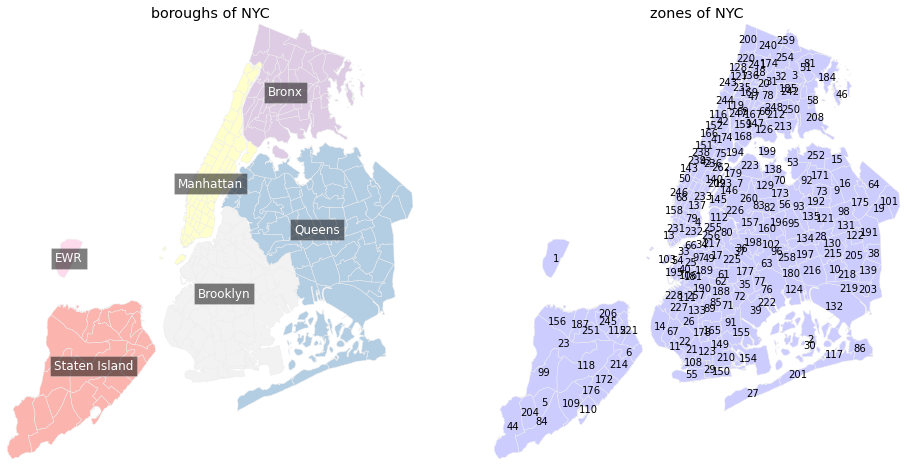

In [14]:
# Plot method from following websites
# https://gis.stackexchange.com/questions/240548/plotting-shapefiles-with-pyshp-in-python-omits-some-shapes
# https://www.programcreek.com/python/example/102297/matplotlib.pyplot.text

fig, ax = plt.pyplot.subplots(nrows=1, ncols=2, figsize=(16,8))
ax = plt.pyplot.subplot(1, 2, 1)
ax.axis('off')
ax.set_title("boroughs of NYC")
plot_region(ax, zone, zone_dic)
ax = plt.pyplot.subplot(1, 2, 2)
ax.axis('off')
ax.set_title("zones of NYC")
plot_zone(ax, zone, zone_dic)

## Which zone for most pickup and dropoff?

In [15]:
df_green_pick = count_freq(df_green, 'PULocationID', ['PULocationID', 'pickup_count'])
df_green_drop = count_freq(df_green, 'DOLocationID', ['DOLocationID', 'dropoff_count'])
df_yellow_pick = count_freq(df_yellow, 'PULocationID', ['PULocationID', 'pickup_count'])
df_yellow_drop = count_freq(df_yellow, 'DOLocationID', ['DOLocationID', 'dropoff_count'])

In [16]:
df_green_drop

,DOLocationID,dropoff_count
0,1,76
1,2,6
2,3,497
3,4,477
4,5,6
...,...,...
260,261,322
261,262,1780
262,263,4089
263,264,506


In [17]:
loc = df_loc[["LocationID", "zone", "borough"]]
df_pu = df_green_pick
df_pu = df_pu.rename(columns={'PULocationID':'LocationID'})
df_do = df_green_drop
df_do = df_do.rename(columns={'DOLocationID':'LocationID'})
df_green_pd = pd.concat([df_pu.reset_index(drop=True), df_do], axis=1)
df_green_pd = df_green_pd.loc[:,~df_green_pd.columns.duplicated()]
df_green_pd['total_count'] = df_green_pd['pickup_count'] + df_green_pd['dropoff_count']
df_green_pd = df_green_pd.merge(loc, left_on="LocationID", right_on="LocationID")
df_green_pd

,LocationID,pickup_count,dropoff_count,total_count,zone,borough
0,1,1,76,77,Newark Airport,EWR
1,2,1,6,7,Jamaica Bay,Queens
2,3,474,497,971,Allerton/Pelham Gardens,Bronx
3,4,66,477,543,Alphabet City,Manhattan
4,5,4,6,10,Arden Heights,Staten Island
...,...,...,...,...,...,...
258,259,579,615,1194,Woodlawn/Wakefield,Bronx
259,260,3956,2456,6412,Woodside,Queens
260,261,27,322,349,World Trade Center,Manhattan
261,262,47,1780,1827,Yorkville East,Manhattan


In [18]:
# Convert pandas series to dictionary, method from:
# https://stackoverflow.com/questions/29403192/convert-series-returned-by-pandas-series-value-counts-to-a-dictionary
green_pick_count = dict(zip(df_green_pd['LocationID'].tolist(), df_green_pd['pickup_count'].tolist()))
green_drop_count = dict(zip(df_green_pd['LocationID'].tolist(), df_green_pd['dropoff_count'].tolist()))
green_pick_top = df_green_pd.sort_values(by=['pickup_count'], ascending=False).head()
green_drop_top = df_green_pd.sort_values(by=['dropoff_count'], ascending=False).head()

In [19]:
loc = df_loc[["LocationID", "zone", "borough"]]
df_pu = df_yellow_pick
df_pu = df_pu.rename(columns={'PULocationID':'LocationID'})
df_do = df_yellow_drop
df_do = df_do.rename(columns={'DOLocationID':'LocationID'})
df_yellow_pd = pd.concat([df_pu.reset_index(drop=True), df_do], axis=1)
df_yellow_pd = df_yellow_pd.loc[:,~df_yellow_pd.columns.duplicated()]
df_yellow_pd['total_count'] = df_yellow_pd['pickup_count'] + df_yellow_pd['dropoff_count']
df_yellow_pd = df_yellow_pd.merge(loc, left_on="LocationID", right_on="LocationID")
df_yellow_pd

,LocationID,pickup_count,dropoff_count,total_count,zone,borough
0,1,108,5606,5714,Newark Airport,EWR
1,2,5,7,12,Jamaica Bay,Queens
2,3,339,659,998,Allerton/Pelham Gardens,Bronx
3,4,6548,19401,25949,Alphabet City,Manhattan
4,5,10,55,65,Arden Heights,Staten Island
...,...,...,...,...,...,...
258,259,615,1189,1804,Woodlawn/Wakefield,Bronx
259,260,2488,5740,8228,Woodside,Queens
260,261,17134,14417,31551,World Trade Center,Manhattan
261,262,61968,62236,124204,Yorkville East,Manhattan


In [20]:
# Convert pandas series to dictionary, method from:
# https://stackoverflow.com/questions/29403192/convert-series-returned-by-pandas-series-value-counts-to-a-dictionary
yellow_pick_count = dict(zip(df_yellow_pd['LocationID'].tolist(), df_yellow_pd['pickup_count'].tolist()))
yellow_drop_count = dict(zip(df_yellow_pd['LocationID'].tolist(), df_yellow_pd['dropoff_count'].tolist()))
yellow_pick_top = df_yellow_pd.sort_values(by=['pickup_count'], ascending=False).head()
yellow_drop_top = df_yellow_pd.sort_values(by=['dropoff_count'], ascending=False).head()

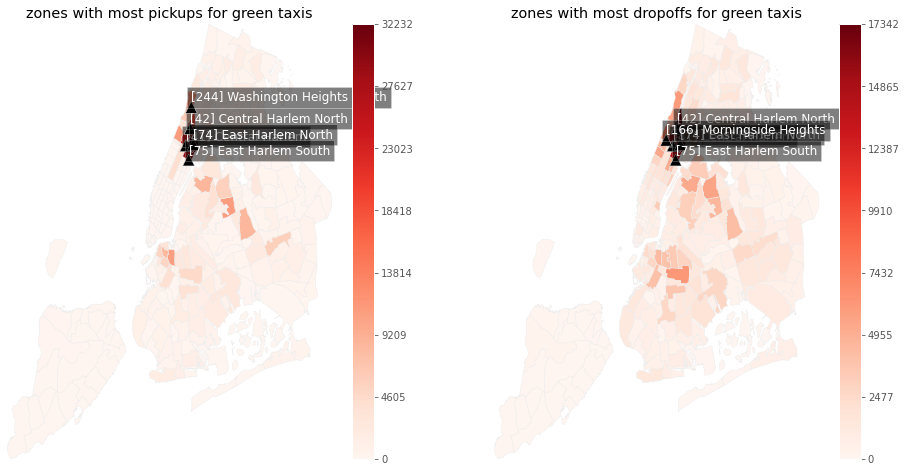

In [21]:
fig, ax = plt.pyplot.subplots(nrows=1, ncols=2, figsize=(16,8))
ax = plt.pyplot.subplot(1, 2, 1)
ax.axis('off')
ax.set_title("zones with most pickups for green taxis")
plot_zone(ax, zone, zone_dic, heat=green_pick_count, text=green_pick_top['LocationID'].to_list())
ax = plt.pyplot.subplot(1, 2, 2)
ax.axis('off')
ax.set_title("zones with most dropoffs for green taxis")
plot_zone(ax, zone, zone_dic, heat=green_drop_count, text=green_drop_top['LocationID'].to_list())

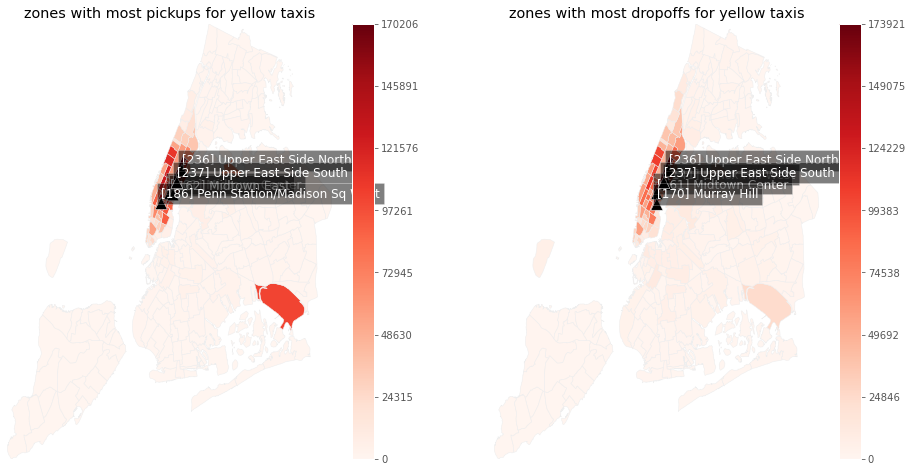

In [22]:
fig, ax = plt.pyplot.subplots(nrows=1, ncols=2, figsize=(16,8))
ax = plt.pyplot.subplot(1, 2, 1)
ax.axis('off')
ax.set_title("zones with most pickups for yellow taxis")
plot_zone(ax, zone, zone_dic, heat=yellow_pick_count, text=yellow_pick_top['LocationID'].to_list())
ax = plt.pyplot.subplot(1, 2, 2)
ax.axis('off')
ax.set_title("zones with most dropoffs for yellow taxis")
plot_zone(ax, zone, zone_dic, heat=yellow_drop_count, text=yellow_drop_top['LocationID'].to_list())

## Which borough for most pickup and dropoff?

In [23]:
# Convert pandas series to dictionary, method from:
# https://stackoverflow.com/questions/29403192/convert-series-returned-by-pandas-series-value-counts-to-a-dictionary
df_green_pd_reg = df_green_pd.groupby('borough', as_index=False)
df_green_pd_reg = df_green_pd_reg.first()

green_pick_reg = dict(zip(df_green_pd_reg['borough'].tolist(), df_green_pd_reg['pickup_count'].tolist()))
green_drop_reg = dict(zip(df_green_pd_reg['borough'].tolist(), df_green_pd_reg['dropoff_count'].tolist()))

In [24]:
# Convert pandas series to dictionary, method from:
# https://stackoverflow.com/questions/29403192/convert-series-returned-by-pandas-series-value-counts-to-a-dictionary
df_yellow_pd_reg = df_yellow_pd.groupby('borough', as_index=False)
df_yellow_pd_reg = df_yellow_pd_reg.first()

yellow_pick_reg = dict(zip(df_yellow_pd_reg['borough'].tolist(), df_yellow_pd_reg['pickup_count'].tolist()))
yellow_drop_reg = dict(zip(df_yellow_pd_reg['borough'].tolist(), df_yellow_pd_reg['dropoff_count'].tolist()))

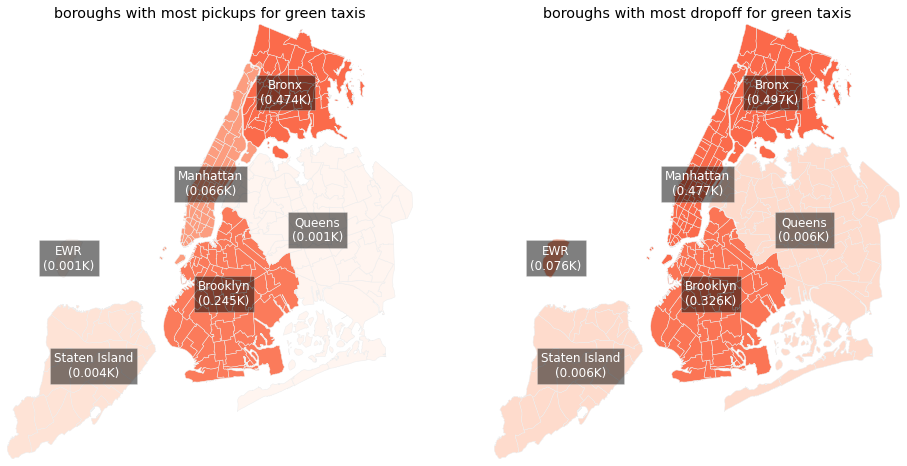

In [25]:
fig, ax = plt.pyplot.subplots(nrows=1, ncols=2, figsize=(16,8))
ax = plt.pyplot.subplot(1, 2, 1)
ax.axis('off')
ax.set_title("boroughs with most pickups for green taxis")
plot_region(ax, zone, zone_dic, heat=green_pick_reg)
ax = plt.pyplot.subplot(1, 2, 2)
ax.axis('off')
ax.set_title("boroughs with most dropoff for green taxis")
plot_region(ax, zone, zone_dic, heat=green_drop_reg)

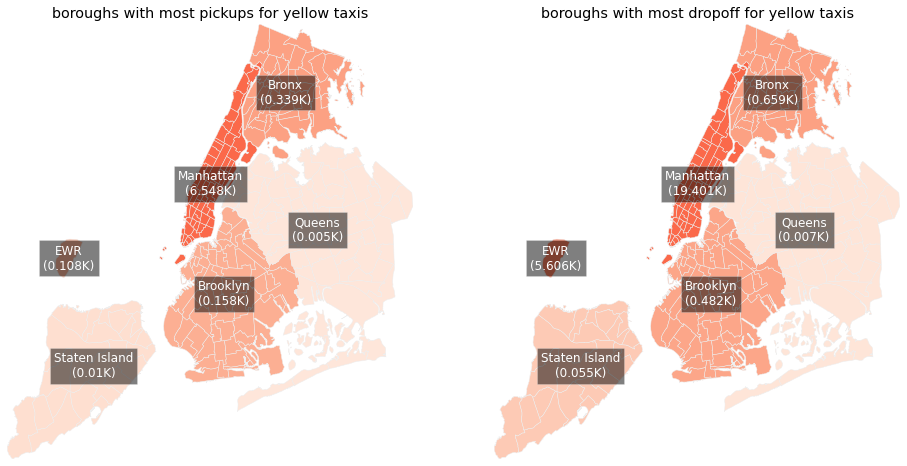

In [26]:
fig, ax = plt.pyplot.subplots(nrows=1, ncols=2, figsize=(16,8))
ax = plt.pyplot.subplot(1, 2, 1)
ax.axis('off')
ax.set_title("boroughs with most pickups for yellow taxis")
plot_region(ax, zone, zone_dic, heat=yellow_pick_reg)
ax = plt.pyplot.subplot(1, 2, 2)
ax.axis('off')
ax.set_title("boroughs with most dropoff for yellow taxis")
plot_region(ax, zone, zone_dic, heat=yellow_drop_reg)

In [27]:
df_green_pt = count_freq(df_green, 'pickup_hour', ['pickup_hour', 'pickup_count'], label='int')
df_green_dt = count_freq(df_green, 'dropoff_hour', ['dropoff_hour', 'dropoff_count'], label='int')
df_yellow_pt = count_freq(df_yellow, 'pickup_hour', ['pickup_hour', 'pickup_count'], label='int')
df_yellow_dt = count_freq(df_yellow, 'dropoff_hour', ['dropoff_hour', 'dropoff_count'], label='int')
df_green_pt

,pickup_hour,pickup_count
0,00,6881
1,01,4600
2,02,2905
3,03,3478
4,04,4655
5,05,4957
6,06,9309
7,07,15474
8,08,20455
9,09,21736


## When is the most popular trip time?

In [28]:
green_pt = df_green_pt['pickup_count'].tolist()
green_dt = df_green_dt['dropoff_count'].tolist()
yellow_pt = df_yellow_pt['pickup_count'].tolist()
yellow_dt = df_yellow_dt['dropoff_count'].tolist()

In [29]:
labels = ['{0:0=2d}'.format(i) for i in range(24)]
width = 0.35
x = np.arange(len(labels))
plt.pyplot.rcParams.update({'font.size': 20})

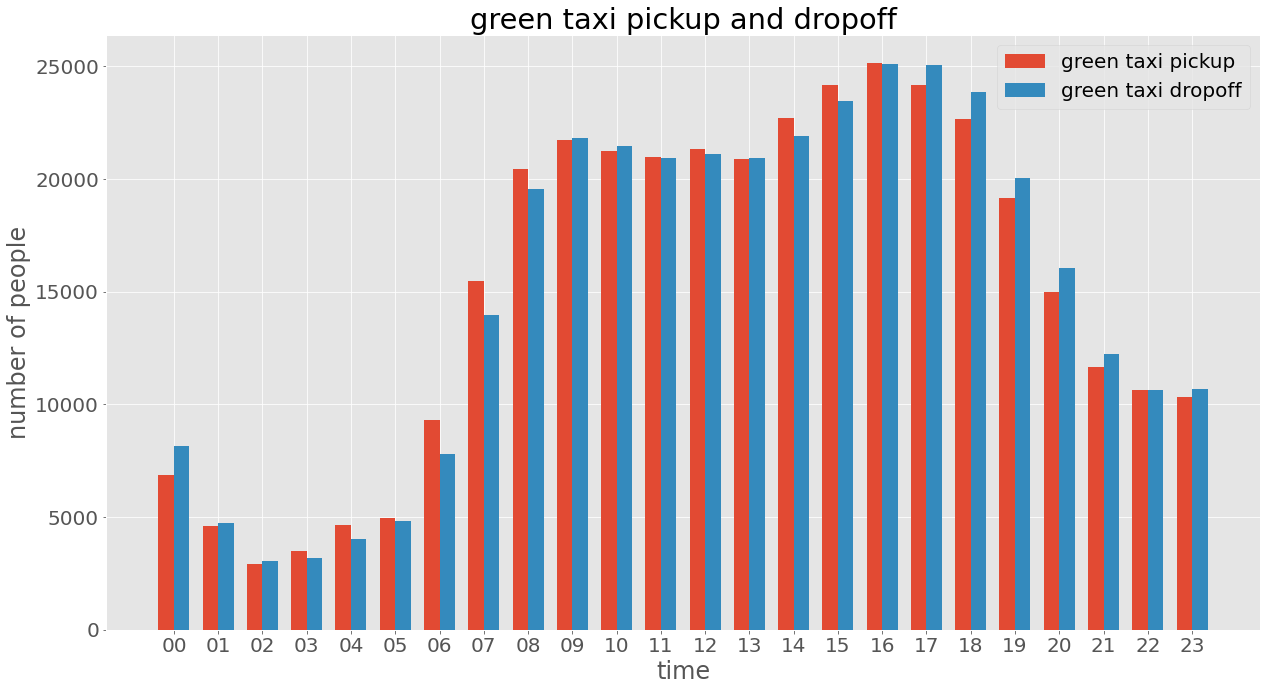

In [30]:
fig, ax = plt.pyplot.subplots()
rects1 = ax.bar(x - width/2, green_pt, width, label='green taxi pickup')
rects2 = ax.bar(x + width/2, green_dt, width, label='green taxi dropoff')

fig = plt.pyplot.gcf()
fig.set_size_inches(18, 10)

ax.set_xlabel('time')
ax.set_ylabel('number of people')
ax.set_title('green taxi pickup and dropoff')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
fig.tight_layout()
plt.pyplot.show()

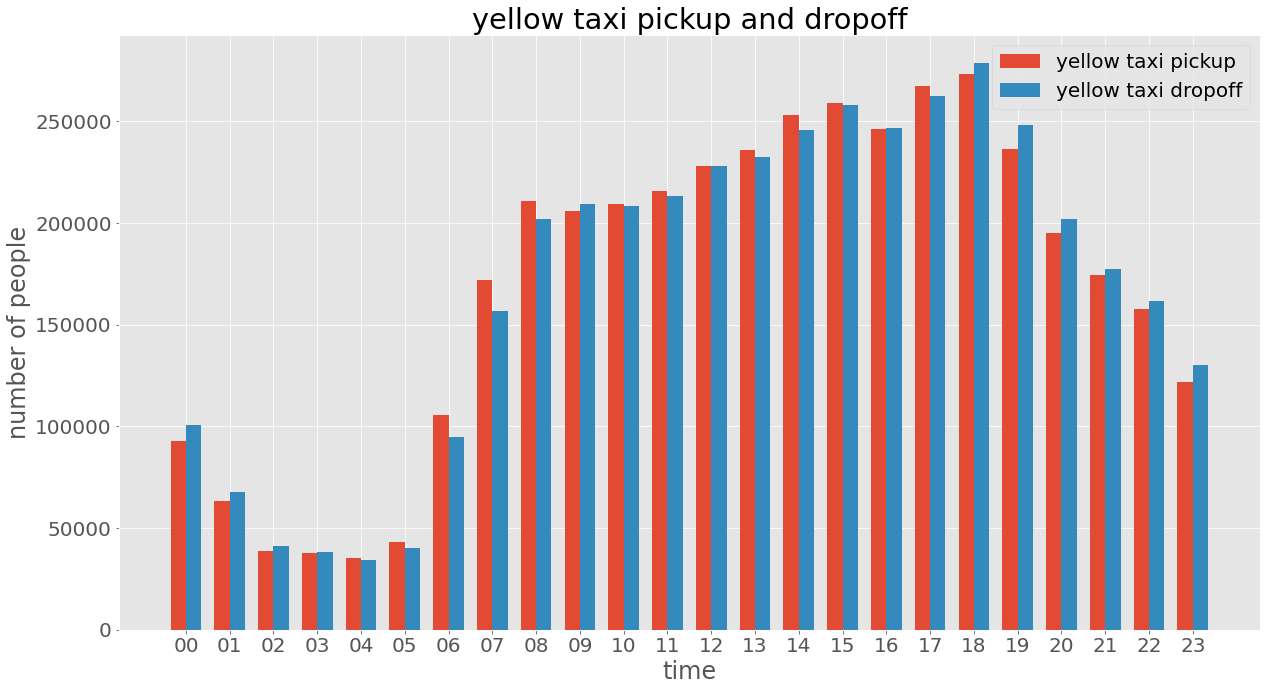

In [31]:
fig, ax = plt.pyplot.subplots()
rects1 = ax.bar(x - width/2, yellow_pt, width, label='yellow taxi pickup')
rects2 = ax.bar(x + width/2, yellow_dt, width, label='yellow taxi dropoff')

fig = plt.pyplot.gcf()
fig.set_size_inches(18, 10)

ax.set_xlabel('time')
ax.set_ylabel('number of people')
ax.set_title('yellow taxi pickup and dropoff')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
fig.tight_layout()
plt.pyplot.show()

## How far do people mostly travel?

In [32]:
df_green_mt = count_freq(df_green, 'trip_distance', ['trip_distance', 'pickup_count'], label='int')
df_yellow_mt = count_freq(df_yellow, 'trip_distance', ['trip_distance', 'pickup_count'], label='int')

# Remove outliers
df_green_mt = df_green_mt[df_green_mt['trip_distance'] < 1000]
df_yellow_mt = df_yellow_mt[df_yellow_mt['trip_distance'] < 1000]

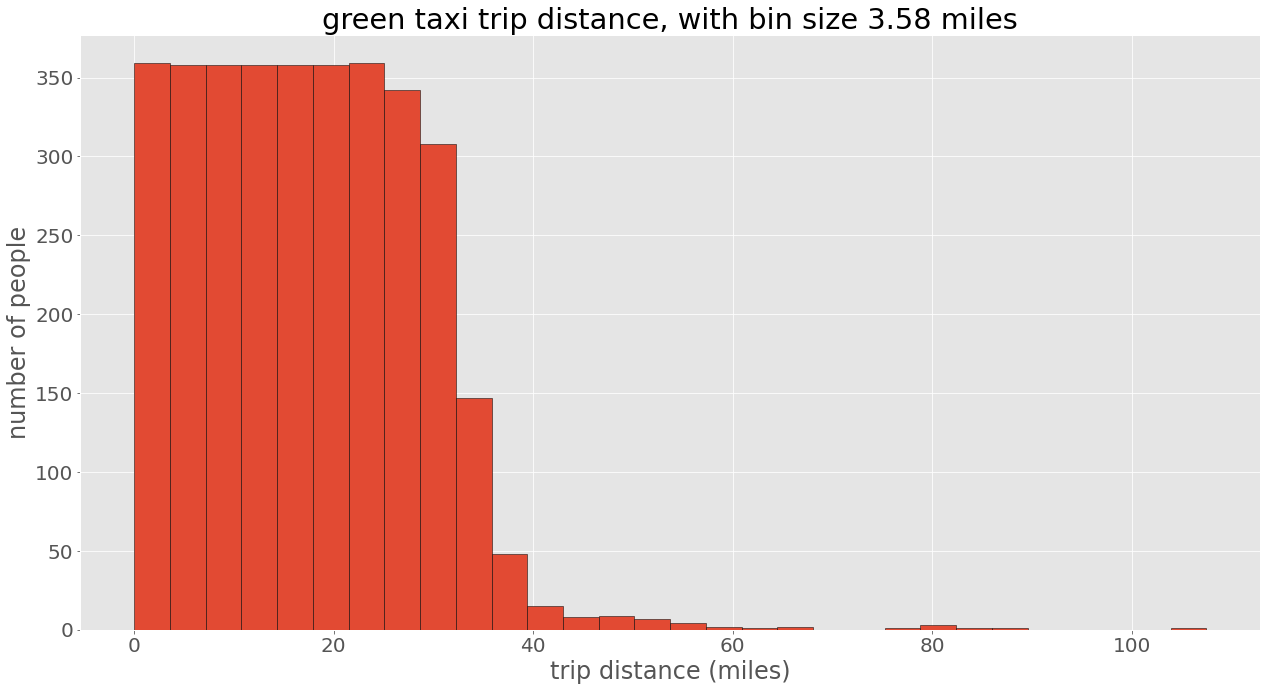

In [33]:
fig, ax = plt.pyplot.subplots(sharey=True, tight_layout=True)
fig.set_size_inches(18, 10)
x = df_green_mt['trip_distance'].tolist()
counts, bins, bars = plt.pyplot.hist(x, bins=30, ec='black')
bin_size = bins[1]-bins[0]
ax.set_xlabel('trip distance (miles)')
ax.set_ylabel('number of people')
ax.set_title('green taxi trip distance, with bin size {0:.2f} miles'.format(bin_size))
plt.pyplot.show()

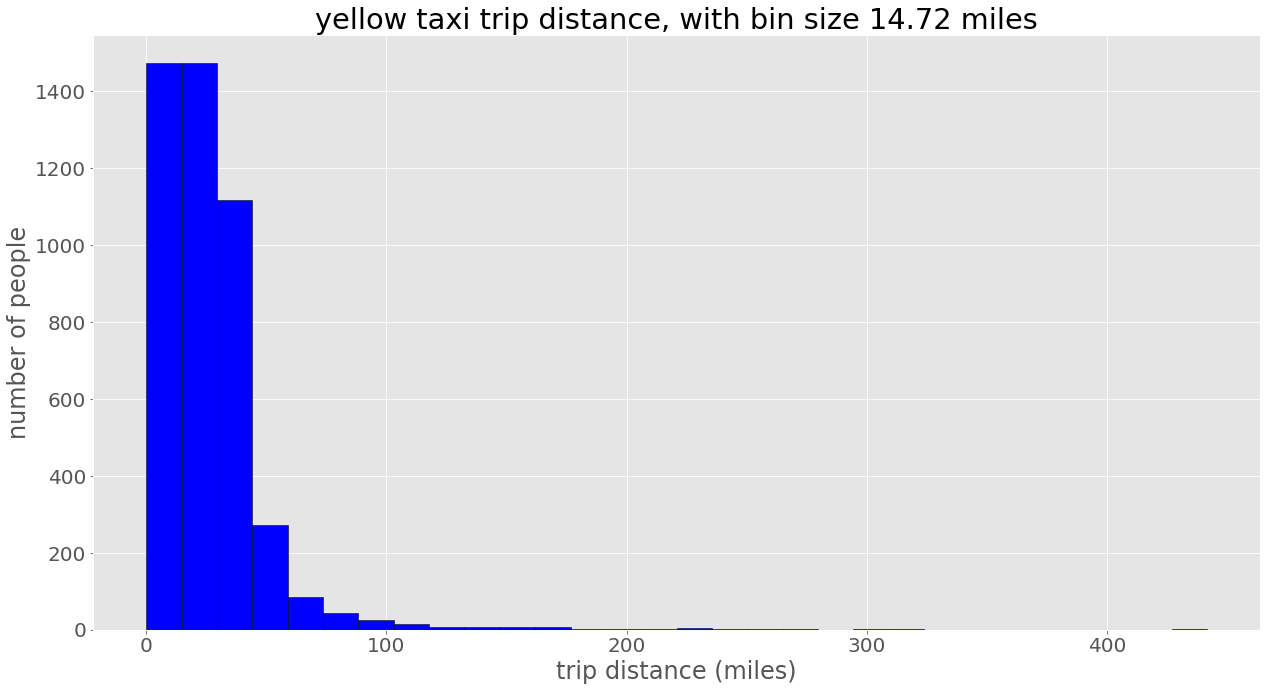

In [34]:
fig, ax = plt.pyplot.subplots(sharey=True, tight_layout=True)
fig.set_size_inches(18, 10)
x = df_yellow_mt['trip_distance'].tolist()
counts, bins, bars = plt.pyplot.hist(x, bins=30, color='blue', ec='black')
bin_size = bins[1]-bins[0]
ax.set_xlabel('trip distance (miles)')
ax.set_ylabel('number of people')
ax.set_title('yellow taxi trip distance, with bin size {0:.2f} miles'.format(bin_size))
plt.pyplot.show()

In [35]:
import geopandas as gpd
from dask.distributed import Client
from shapely.geometry import Point

from bokeh.io import output_notebook
from bokeh.models import GeoJSONDataSource, HoverTool, CategoricalColorMapper, LinearColorMapper, ContinuousColorMapper
from bokeh.plotting import figure, show
from bokeh.palettes import Category10, viridis, plasma, RdBu
from bokeh.models import ColorBar, LogColorMapper, ColumnDataSource, Grid, LinearAxis, Patches, Plot, BasicTicker, FixedTicker
from collections import OrderedDict

import dask.dataframe as dd
import dask

In [36]:
zones = gpd.read_file('dataset/taxi_zones/taxi_zones.shp').to_crs({'init' :'epsg:4326'})
zones

D:\Anaconda\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((-74.18445 40.69500, -74.18449 40.695..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((-73.84793 40.87134, -73.84725 40.870..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((-73.97177 40.72582, -73.97179 40.725..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((-74.17422 40.56257, -74.17349 40.562..."
...,...,...,...,...,...,...,...
258,259,0.126750,0.000395,Woodlawn/Wakefield,259,Bronx,"POLYGON ((-73.85107 40.91037, -73.85207 40.909..."
259,260,0.133514,0.000422,Woodside,260,Queens,"POLYGON ((-73.90175 40.76078, -73.90147 40.759..."
260,261,0.027120,0.000034,World Trade Center,261,Manhattan,"POLYGON ((-74.01333 40.70503, -74.01327 40.704..."
261,262,0.049064,0.000122,Yorkville East,262,Manhattan,"MULTIPOLYGON (((-73.94383 40.78286, -73.94376 ..."


In [37]:
num_borough = len(zones['borough'].value_counts())
num_zone = len(zones['zone'].value_counts())

In [38]:
source = GeoJSONDataSource(geojson=zones.to_json())

attributes = zones.borough.drop_duplicates()
palette = Category10[num_borough]
color_mapper = CategoricalColorMapper(factors=attributes.tolist(), palette=palette)



fig = figure()
fig.patches(xs='xs', ys='ys', alpha=0.8, source=source, color={'field': 'borough', 'transform': color_mapper})

hover = HoverTool(
    point_policy='follow_mouse',
    tooltips='<p><b>Borough</b>: @borough</p><p><b>LocationID</b>: @LocationID</p>'
)
fig.add_tools(hover)


show(fig)

In [39]:
zones_dic = dict(zip(zones['LocationID'].tolist(), zones['zone'].tolist()))

In [40]:
df_yellow_p = df_yellow.dropna(subset=['passenger_count'])
df_green_p = df_green.dropna(subset=['passenger_count'])

In [41]:
(df_yellow_p['PULocationID'] == 132).value_counts()

False    3812772
True      102177
Name: PULocationID, dtype: int64

In [42]:
df_yellow_p

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,pickup_hour,dropoff_hour
0,1.0,2020-03-01 00:31:13,2020-03-01 01:01:42,1.0,4.70,1.0,N,88,255,1.0,22.0,3.0,0.5,2.00,0.00,0.3,27.80,2.5,00,01
2,1.0,2020-03-01 00:52:18,2020-03-01 00:59:16,1.0,1.10,1.0,N,246,90,1.0,6.0,3.0,0.5,1.95,0.00,0.3,11.75,2.5,00,00
3,2.0,2020-03-01 00:47:53,2020-03-01 00:50:57,2.0,0.87,1.0,N,151,238,1.0,5.0,0.5,0.5,1.76,0.00,0.3,10.56,2.5,00,00
4,1.0,2020-03-01 00:43:19,2020-03-01 00:58:27,0.0,4.40,1.0,N,79,261,1.0,16.5,3.0,0.5,4.05,0.00,0.3,24.35,2.5,00,00
5,1.0,2020-03-01 00:04:43,2020-03-01 00:23:17,1.0,3.50,1.0,Y,113,142,1.0,15.0,3.0,0.5,3.75,0.00,0.3,22.55,2.5,00,00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499038,2.0,2020-06-30 23:07:00,2020-06-30 23:08:46,1.0,1.06,1.0,N,74,194,2.0,5.0,0.5,0.5,0.00,6.12,0.3,12.42,0.0,23,23
499039,2.0,2020-06-30 23:24:49,2020-06-30 23:32:00,1.0,1.52,1.0,N,138,70,1.0,7.5,0.5,0.5,1.76,0.00,0.3,10.56,0.0,23,23
499040,2.0,2020-06-30 23:57:38,2020-07-01 00:24:57,1.0,13.36,1.0,N,138,259,2.0,37.5,0.5,0.5,0.00,6.12,0.3,44.92,0.0,23,00
499041,2.0,2020-06-30 23:08:03,2020-06-30 23:26:37,1.0,2.23,1.0,N,41,41,2.0,13.5,0.5,0.5,0.00,0.00,0.3,14.80,0.0,23,23


In [43]:
def select_attribute(df, attribute='PULocationID'):
    dic = df.passenger_count.groupby(df[attribute]).count().to_dict()
    for i in range(1, 264):
        if i not in dic.keys():
            dic[i] = 0
    dic = dict(OrderedDict(sorted(dic.items())))
    se = pd.Series(dic)
    return pd.DataFrame({'{}'.format(attribute):se.index, 'passenger_count':se.values})

In [44]:
df_yellow_p_pick = select_attribute(df_yellow_p, 'PULocationID')
df_yellow_p_drop = select_attribute(df_yellow_p, 'DOLocationID')
df_green_p_pick = select_attribute(df_green_p, 'PULocationID')
df_green_p_drop = select_attribute(df_green_p, 'DOLocationID')

In [45]:
df_yellow_pj = zones
df_yellow_dj = zones
df_green_pj = zones
df_green_dj = zones

In [46]:
df_yellow_pj['passenger_count'] = df_yellow_p_pick['passenger_count']
source = GeoJSONDataSource(geojson=df_yellow_pj.to_json())

color_mapper = LinearColorMapper(palette="Turbo256", low=0, high=df_yellow_pj['passenger_count'].max())

fig = figure(title='number of pick up for yellow taxis')
fig.title.text_font_size = '14pt'
fig.patches(xs='xs', ys='ys', alpha=0.9, source=source, color={'field': 'passenger_count', 'transform': color_mapper}, line_width=1, line_alpha=0.5, line_color='black')

hover = HoverTool(
    point_policy='follow_mouse',
    tooltips=('<div><b>Borough</b>: @borough</div>'
              '<div><b>Zone</b>: @zone</div>'
              '<div><b>LocationID</b>: @LocationID</div>'
              '<div><b>Rides</b>: @passenger_count</div>')
)
fig.add_tools(hover)

fig.xaxis.visible = False
fig.yaxis.visible = False
fig.grid.visible = False

color_bar = ColorBar(color_mapper=color_mapper, ticker=BasicTicker(), location=(0, 0), label_standoff=12)
fig.add_layout(color_bar, 'right')

show(fig)

In [47]:
df_yellow_dj['passenger_count'] = df_yellow_p_drop['passenger_count']
source = GeoJSONDataSource(geojson=df_yellow_dj.to_json())

color_mapper = LinearColorMapper(palette="Turbo256", low=0, high=df_yellow_dj['passenger_count'].max())

fig = figure(title='number of drop off for yellow taxis')
fig.title.text_font_size = '14pt'
fig.patches(xs='xs', ys='ys', alpha=0.9, source=source, color={'field': 'passenger_count', 'transform': color_mapper}, line_width=1, line_alpha=0.5, line_color='black')

hover = HoverTool(
    point_policy='follow_mouse',
    tooltips=('<div><b>Borough</b>: @borough</div>'
              '<div><b>Zone</b>: @zone</div>'
              '<div><b>LocationID</b>: @LocationID</div>'
              '<div><b>Rides</b>: @passenger_count</div>')
)
fig.add_tools(hover)

fig.xaxis.visible = False
fig.yaxis.visible = False
fig.grid.visible = False

color_bar = ColorBar(color_mapper=color_mapper, ticker=BasicTicker(), location=(0, 0), label_standoff=12)
fig.add_layout(color_bar, 'right')

show(fig)

In [48]:
df_green_pj['passenger_count'] = df_green_p_pick['passenger_count']
source = GeoJSONDataSource(geojson=df_green_pj.to_json())

color_mapper = LinearColorMapper(palette="Turbo256", low=0, high=df_green_pj['passenger_count'].max())

fig = figure(title='number of pick up for green taxis')
fig.title.text_font_size = '14pt'
fig.patches(xs='xs', ys='ys', alpha=0.9, source=source, color={'field': 'passenger_count', 'transform': color_mapper}, line_width=1, line_alpha=0.5, line_color='black')

hover = HoverTool(
    point_policy='follow_mouse',
    tooltips=('<div><b>Borough</b>: @borough</div>'
              '<div><b>Zone</b>: @zone</div>'
              '<div><b>LocationID</b>: @LocationID</div>'
              '<div><b>Rides</b>: @passenger_count</div>')
)
fig.add_tools(hover)

fig.xaxis.visible = False
fig.yaxis.visible = False
fig.grid.visible = False

color_bar = ColorBar(color_mapper=color_mapper, ticker=BasicTicker(), location=(0, 0), label_standoff=12)
fig.add_layout(color_bar, 'right')

show(fig)

In [49]:
df_green_dj['passenger_count'] = df_green_p_drop['passenger_count']
source = GeoJSONDataSource(geojson=df_green_dj.to_json())

color_mapper = LinearColorMapper(palette="Turbo256", low=0, high=df_green_dj['passenger_count'].max())

fig = figure(title='number of drop off for green taxis')
fig.title.text_font_size = '14pt'
fig.patches(xs='xs', ys='ys', alpha=0.9, source=source, color={'field': 'passenger_count', 'transform': color_mapper}, line_width=1, line_alpha=0.5, line_color='black')

hover = HoverTool(
    point_policy='follow_mouse',
    tooltips=('<div><b>Borough</b>: @borough</div>'
              '<div><b>Zone</b>: @zone</div>'
              '<div><b>LocationID</b>: @LocationID</div>'
              '<div><b>Rides</b>: @passenger_count</div>')
)
fig.add_tools(hover)

fig.xaxis.visible = False
fig.yaxis.visible = False
fig.grid.visible = False

color_bar = ColorBar(color_mapper=color_mapper, ticker=BasicTicker(), location=(0, 0), label_standoff=12)
fig.add_layout(color_bar, 'right')

show(fig)

In [50]:
df_g_jfk = df_green_p[df_green_p['PULocationID'] == 132]
df_y_jfk = df_yellow_p[df_yellow_p['PULocationID'] == 132]

In [51]:
df_green_jfk = select_attribute(df_g_jfk, attribute='DOLocationID')
df_yellow_jfk = select_attribute(df_y_jfk, attribute='DOLocationID')

In [52]:
df_green_jfk_j = zones
df_green_jfk_j['passenger_count'] = df_green_jfk['passenger_count']
source = GeoJSONDataSource(geojson=df_green_jfk_j.to_json())

color_mapper = LinearColorMapper(palette="Plasma256", low=0, high=df_green_jfk_j['passenger_count'].max())

fig = figure(title='number of people who take ride from JFK Airport for green taxis')
fig.title.text_font_size = '14pt'
fig.patches(xs='xs', ys='ys', alpha=0.9, source=source, color={'field': 'passenger_count', 'transform': color_mapper}, line_width=1, line_alpha=0.5, line_color='black')

hover = HoverTool(
    point_policy='follow_mouse',
    tooltips=('<div><b>Borough</b>: @borough</div>'
              '<div><b>Zone</b>: @zone</div>'
              '<div><b>LocationID</b>: @LocationID</div>'
              '<div><b>Rides</b>: @passenger_count</div>')
)
fig.add_tools(hover)

fig.xaxis.visible = False
fig.yaxis.visible = False
fig.grid.visible = False

color_bar = ColorBar(color_mapper=color_mapper, ticker=BasicTicker(), location=(0, 0), label_standoff=12)
fig.add_layout(color_bar, 'right')

show(fig)

In [53]:
df_yellow_jfk_j = zones
df_yellow_jfk_j['passenger_count'] = df_yellow_jfk['passenger_count']
source = GeoJSONDataSource(geojson=df_yellow_jfk_j.to_json())

color_mapper = LinearColorMapper(palette="Plasma256", low=0, high=df_yellow_jfk_j['passenger_count'].max())

fig = figure(title='number of people who take ride from JFK Airport for yellow taxis')
fig.title.text_font_size = '14pt'
fig.patches(xs='xs', ys='ys', alpha=0.9, source=source, color={'field': 'passenger_count', 'transform': color_mapper}, line_width=1, line_alpha=0.5, line_color='black')

hover = HoverTool(
    point_policy='follow_mouse',
    tooltips=('<div><b>Borough</b>: @borough</div>'
              '<div><b>Zone</b>: @zone</div>'
              '<div><b>LocationID</b>: @LocationID</div>'
              '<div><b>Rides</b>: @passenger_count</div>')
)
fig.add_tools(hover)

fig.xaxis.visible = False
fig.yaxis.visible = False
fig.grid.visible = False

color_bar = ColorBar(color_mapper=color_mapper, ticker=BasicTicker(), location=(0, 0), label_standoff=12)
fig.add_layout(color_bar, 'right')

show(fig)

In [54]:
df_green_p

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,pickup_hour,dropoff_hour
0,2.0,2020-03-01 00:20:18,2020-03-01 00:45:29,N,1.0,41,13,1.0,8.24,26.5,...,7.64,0.0,NaN,0.3,38.19,1.0,1.0,2.75,00,00
1,2.0,2020-03-01 00:15:42,2020-03-01 00:44:36,N,1.0,181,107,1.0,4.87,21.0,...,0.00,0.0,NaN,0.3,25.05,2.0,1.0,2.75,00,00
2,2.0,2020-03-01 00:36:18,2020-03-01 00:41:03,N,1.0,41,166,1.0,0.69,5.0,...,0.00,0.0,NaN,0.3,6.30,2.0,1.0,0.00,00,00
3,1.0,2020-03-01 00:22:14,2020-03-01 00:32:57,N,1.0,129,7,1.0,1.80,9.0,...,0.00,0.0,NaN,0.3,10.30,2.0,1.0,0.00,00,00
4,2.0,2020-03-01 00:07:22,2020-03-01 00:14:16,N,1.0,74,152,1.0,1.25,7.0,...,2.49,0.0,NaN,0.3,10.79,1.0,1.0,0.00,00,00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38426,2.0,2020-06-30 23:20:04,2020-06-30 23:25:19,N,1.0,42,168,1.0,1.00,6.0,...,0.00,0.0,NaN,0.3,7.30,2.0,1.0,0.00,23,23
38427,2.0,2020-06-30 23:52:09,2020-06-30 23:55:45,N,1.0,75,74,1.0,0.76,4.5,...,0.00,0.0,NaN,0.3,5.80,2.0,1.0,0.00,23,23
38428,2.0,2020-06-30 22:57:14,2020-06-30 23:13:06,N,1.0,41,244,1.0,2.86,13.0,...,2.86,0.0,NaN,0.3,17.16,1.0,1.0,0.00,22,23
38429,2.0,2020-06-30 23:17:53,2020-06-30 23:39:10,N,1.0,116,68,1.0,7.30,24.0,...,0.00,0.0,NaN,0.3,28.05,1.0,1.0,2.75,23,23


In [55]:
df_green2 = df_green_p
df_yellow2 = df_yellow_p

df_green2['tip_fraction'] = df_green2['tip_amount']/df_green2['fare_amount']
df_yellow2['tip_fraction'] = df_yellow2['tip_amount']/df_yellow2['fare_amount']


<ipython-input-55-4d4573ad12e9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_green2['tip_fraction'] = df_green2['tip_amount']/df_green2['fare_amount']
<ipython-input-55-4d4573ad12e9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_yellow2['tip_fraction'] = df_yellow2['tip_amount']/df_yellow2['fare_amount']


In [56]:
df_green2 = df_green2[df_green2['trip_distance'] < 1000]
df_yellow2 = df_yellow2[df_yellow2['trip_distance'] < 5000]
df_yellow2 = df_yellow2[df_yellow2['tip_fraction'] < 1000]

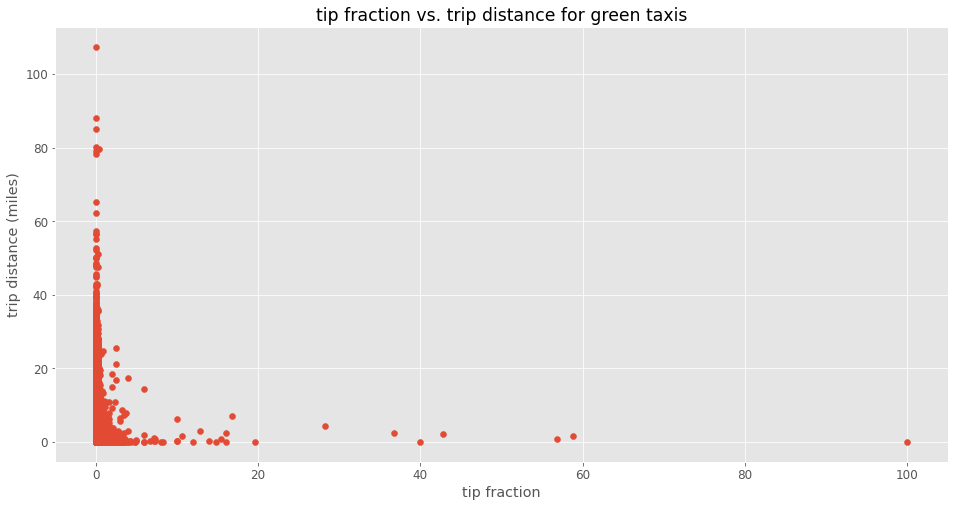

In [57]:
matplotlib.rcParams.update({'font.size': 12})
plt.pyplot.figure(figsize=(16, 8))
plt.pyplot.scatter(df_green2.tip_fraction, df_green2.trip_distance)
plt.pyplot.title("tip fraction vs. trip distance for green taxis")
plt.pyplot.xlabel('tip fraction')
plt.pyplot.ylabel('trip distance (miles)')
plt.pyplot.show()

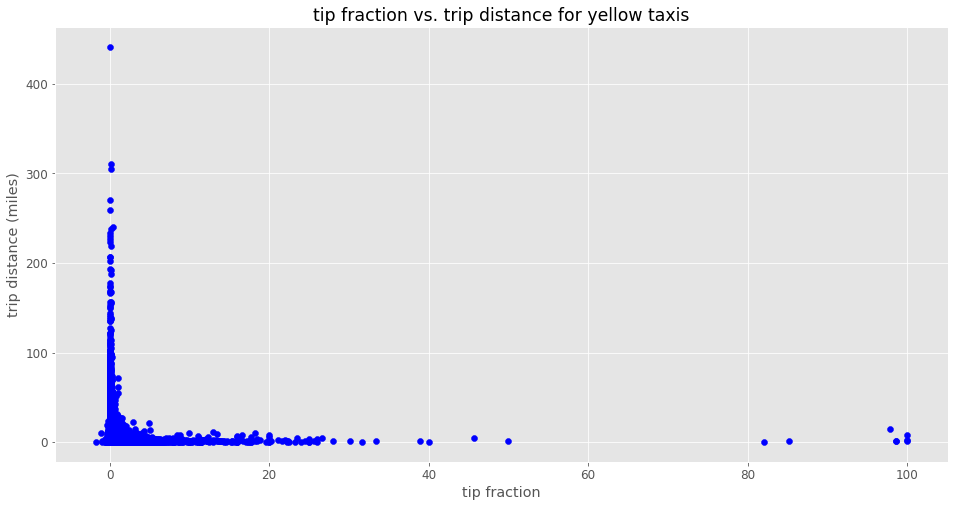

In [58]:
plt.pyplot.figure(figsize=(16, 8))
plt.pyplot.scatter(df_yellow2.tip_fraction, df_yellow2.trip_distance, color='blue')
plt.pyplot.title("tip fraction vs. trip distance for yellow taxis")
plt.pyplot.xlabel('tip fraction')
plt.pyplot.ylabel('trip distance (miles)')
plt.pyplot.show()

In [59]:
df_green_tn = df_green.groupby('DOLocationID').first()
df_yellow_tn = df_yellow.groupby('DOLocationID').first()

In [60]:
df_green_tn['tip_fraction'] = df_green_tn['tip_amount']/df_green_tn['total_amount']
df_yellow_tn['tip_fraction'] = df_yellow_tn['tip_amount']/df_yellow_tn['total_amount']

In [61]:
df_yellow_tn

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,pickup_hour,dropoff_hour,tip_fraction
DOLocationID,,,,,,,,,,,,,,,,,,,,
1,2.0,2020-03-01 02:05:47,2020-03-01 03:03:26,1.0,36.17,3.0,N,132,2.0,110.5,0.5,0.0,0.00,24.74,0.3,136.04,0.0,02,03,0.000000
2,2.0,2020-03-07 14:14:53,2020-03-07 14:52:12,1.0,11.44,1.0,N,55,1.0,37.5,0.0,0.5,5.00,6.12,0.3,49.42,0.0,14,14,0.101174
3,2.0,2020-03-01 01:06:33,2020-03-01 01:38:47,2.0,20.34,1.0,N,132,1.0,55.0,0.5,0.5,5.00,6.12,0.3,67.42,0.0,01,01,0.074162
4,2.0,2020-03-01 00:05:13,2020-03-01 00:20:20,1.0,1.45,1.0,N,211,1.0,9.0,0.5,0.5,2.56,0.00,0.3,15.36,2.5,00,00,0.166667
5,2.0,2020-03-02 16:20:20,2020-03-02 17:32:07,1.0,29.32,1.0,N,161,1.0,83.5,1.0,0.5,24.66,35.50,0.3,147.96,2.5,16,17,0.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,1.0,2020-03-01 00:43:19,2020-03-01 00:58:27,0.0,4.40,1.0,N,79,1.0,16.5,3.0,0.5,4.05,0.00,0.3,24.35,2.5,00,00,0.166324
262,2.0,2020-03-01 00:05:56,2020-03-01 00:11:27,2.0,1.52,1.0,N,237,1.0,6.5,0.5,0.5,2.06,0.00,0.3,12.36,2.5,00,00,0.166667
263,2.0,2020-03-01 00:25:09,2020-03-01 00:43:21,1.0,3.33,1.0,N,107,1.0,14.0,0.5,0.5,3.20,0.00,0.3,21.00,2.5,00,00,0.152381


In [62]:
df_yellow_tnj = zones
df_yellow_tnj['tip_fraction'] = df_yellow_tn['tip_fraction']
source = GeoJSONDataSource(geojson=df_yellow_tnj.to_json())

color_mapper = LinearColorMapper(palette="RdPu9", low=0, high=df_yellow_tnj['tip_fraction'].max())

fig = figure(title='average tip fraction for yellow taxis')
fig.title.text_font_size = '14pt'
fig.patches(xs='xs', ys='ys', alpha=0.9, source=source, color={'field': 'tip_fraction', 'transform': color_mapper}, line_width=1, line_alpha=0.5, line_color='black')

hover = HoverTool(
    point_policy='follow_mouse',
    tooltips=('<div><b>Borough</b>: @borough</div>'
              '<div><b>Zone</b>: @zone</div>'
              '<div><b>LocationID</b>: @LocationID</div>'
              '<div><b>tip_fraction</b>: @tip_fraction</div>')
)
fig.add_tools(hover)

fig.xaxis.visible = False
fig.yaxis.visible = False
fig.grid.visible = False

color_bar = ColorBar(color_mapper=color_mapper, ticker=BasicTicker(), location=(0, 0), label_standoff=12)
fig.add_layout(color_bar, 'right')

show(fig)

In [63]:
df_green_tnj = zones
df_green_tnj['tip_fraction'] = df_green_tn['tip_fraction']
source = GeoJSONDataSource(geojson=df_green_tnj.to_json())

color_mapper = LinearColorMapper(palette="RdPu9", low=0, high=df_green_tnj['tip_fraction'].max())

fig = figure(title='average tip fraction for green taxis')
fig.title.text_font_size = '14pt'
fig.patches(xs='xs', ys='ys', alpha=0.9, source=source, color={'field': 'tip_fraction', 'transform': color_mapper}, line_width=1, line_alpha=0.5, line_color='black')

hover = HoverTool(
    point_policy='follow_mouse',
    tooltips=('<div><b>Borough</b>: @borough</div>'
              '<div><b>Zone</b>: @zone</div>'
              '<div><b>LocationID</b>: @LocationID</div>'
              '<div><b>tip_fraction</b>: @tip_fraction</div>')
)
fig.add_tools(hover)

fig.xaxis.visible = False
fig.yaxis.visible = False
fig.grid.visible = False

color_bar = ColorBar(color_mapper=color_mapper, ticker=BasicTicker(), location=(0, 0), label_standoff=12)
fig.add_layout(color_bar, 'right')

show(fig)

In [64]:
def select_attribute(df, attribute='PULocationID'):
    dic = df.passenger_count.groupby(df[attribute]).count().to_dict()
    for i in range(1, 264):
        if i not in dic.keys():
            dic[i] = 0
    dic = dict(OrderedDict(sorted(dic.items())))
    se = pd.Series(dic)
    return pd.DataFrame({'{}'.format(attribute):se.index, 'passenger_count':se.values})

In [65]:
df_green_pay = df_green2[(df_green2['payment_type'] == 1) | (df_green2['payment_type'] == 2)]
df_yellow_pay = df_yellow2[(df_yellow2['payment_type'] == 1) | (df_yellow2['payment_type'] == 2)]

In [66]:
df_green_card = df_green_pay[df_green_pay['payment_type'] == 1]
df_yellow_card = df_yellow_pay[df_yellow_pay['payment_type'] == 1]

In [67]:
df_green_card = select_attribute(df_green_card, attribute='DOLocationID')
df_yellow_card = select_attribute(df_yellow_card, attribute='DOLocationID')

In [68]:
df_green_card_j = zones
df_green_card_j['passenger_count'] = df_green_card['passenger_count']

source = GeoJSONDataSource(geojson=df_green_card_j.to_json())

color_mapper = LinearColorMapper(palette="RdYlBu11", low=0, high=df_green_card_j['passenger_count'].max())

fig = figure(title='number of people who pay via card for green taxis')
fig.title.text_font_size = '14pt'
fig.patches(xs='xs', ys='ys', alpha=0.9, source=source, color={'field': 'passenger_count', 'transform': color_mapper}, line_width=1, line_alpha=0.5, line_color='black')

hover = HoverTool(
    point_policy='follow_mouse',
    tooltips=('<div><b>Borough</b>: @borough</div>'
              '<div><b>Zone</b>: @zone</div>'
              '<div><b>LocationID</b>: @LocationID</div>'
              '<div><b>Rides</b>: @passenger_count</div>')
)
fig.add_tools(hover)

fig.xaxis.visible = False
fig.yaxis.visible = False
fig.grid.visible = False

color_bar = ColorBar(color_mapper=color_mapper, ticker=BasicTicker(), location=(0, 0), label_standoff=12)
fig.add_layout(color_bar, 'right')

show(fig)

In [69]:
df_yellow_card_j = zones
df_yellow_card_j['passenger_count'] = df_yellow_card['passenger_count']

source = GeoJSONDataSource(geojson=df_yellow_card_j.to_json())

color_mapper = LinearColorMapper(palette="RdYlBu11", low=0, high=df_yellow_card_j['passenger_count'].max())

fig = figure(title='number of people who pay via card for yellow taxis')
fig.title.text_font_size = '14pt'
fig.patches(xs='xs', ys='ys', alpha=0.9, source=source, color={'field': 'passenger_count', 'transform': color_mapper}, line_width=1, line_alpha=0.5, line_color='black')

hover = HoverTool(
    point_policy='follow_mouse',
    tooltips=('<div><b>Borough</b>: @borough</div>'
              '<div><b>Zone</b>: @zone</div>'
              '<div><b>LocationID</b>: @LocationID</div>'
              '<div><b>Rides</b>: @passenger_count</div>')
)
fig.add_tools(hover)

fig.xaxis.visible = False
fig.yaxis.visible = False
fig.grid.visible = False

color_bar = ColorBar(color_mapper=color_mapper, ticker=BasicTicker(), location=(0, 0), label_standoff=12)
fig.add_layout(color_bar, 'right')

show(fig)